In [9]:
%pip install pandas torch tqdm matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [11]:
df = pd.read_csv("../df_unbalanced_classification.csv")

selected_feature = [
    "differentiate",
    "Node Positive Ratio",
    "N Stage Encoded",
    "Estrogen Status Encoded",
    "Progesterone Status Encoded",
]

# X = df.drop(columns=["Survival More Than 6 Years"]).values
X = df[selected_feature].values
y = df["Status_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class SLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
            return torch.argmax(probs, dim=1)

In [13]:
def train(model, train_loader, criterion, optimizer, epochs=50):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0

        for X_batch, y_batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"
        ):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == y_batch).sum().item()

        avg_train_loss = train_loss / len(train_dataset)
        avg_train_acc = train_acc / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_acc = 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(
                test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"
            ):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_acc = val_acc / len(test_dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

In [14]:
model = SLP(input_dim=X_train_tensor.shape[1], output_dim=2)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, criterion, optimizer, epochs=epochs
)

Epoch 1/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4138.91it/s]


Epoch 1/100 - Train Loss: 0.0245, Train Acc: 0.6167, Val Loss: 0.0257, Val Acc: 0.6211


Epoch 2/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5268.21it/s]


Epoch 2/100 - Train Loss: 0.0242, Train Acc: 0.6182, Val Loss: 0.0254, Val Acc: 0.6273


Epoch 3/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5378.37it/s]


Epoch 3/100 - Train Loss: 0.0239, Train Acc: 0.6210, Val Loss: 0.0250, Val Acc: 0.6373


Epoch 4/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5523.57it/s]


Epoch 4/100 - Train Loss: 0.0236, Train Acc: 0.6331, Val Loss: 0.0247, Val Acc: 0.6373


Epoch 5/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5327.92it/s]


Epoch 5/100 - Train Loss: 0.0232, Train Acc: 0.6353, Val Loss: 0.0244, Val Acc: 0.6509


Epoch 6/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5418.73it/s]


Epoch 6/100 - Train Loss: 0.0231, Train Acc: 0.6477, Val Loss: 0.0241, Val Acc: 0.6758


Epoch 7/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5323.76it/s]


Epoch 7/100 - Train Loss: 0.0230, Train Acc: 0.6623, Val Loss: 0.0238, Val Acc: 0.6795


Epoch 8/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5264.39it/s]


Epoch 8/100 - Train Loss: 0.0226, Train Acc: 0.6719, Val Loss: 0.0236, Val Acc: 0.6845


Epoch 9/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5357.50it/s]


Epoch 9/100 - Train Loss: 0.0225, Train Acc: 0.6785, Val Loss: 0.0234, Val Acc: 0.6845


Epoch 10/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4824.45it/s]


Epoch 10/100 - Train Loss: 0.0223, Train Acc: 0.6844, Val Loss: 0.0231, Val Acc: 0.6907


Epoch 11/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5280.20it/s]


Epoch 11/100 - Train Loss: 0.0222, Train Acc: 0.6884, Val Loss: 0.0229, Val Acc: 0.6981


Epoch 12/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5089.94it/s]


Epoch 12/100 - Train Loss: 0.0220, Train Acc: 0.6921, Val Loss: 0.0227, Val Acc: 0.6981


Epoch 13/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5187.76it/s]


Epoch 13/100 - Train Loss: 0.0217, Train Acc: 0.6956, Val Loss: 0.0226, Val Acc: 0.6981


Epoch 14/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5376.52it/s]


Epoch 14/100 - Train Loss: 0.0215, Train Acc: 0.6993, Val Loss: 0.0224, Val Acc: 0.7043


Epoch 15/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5169.07it/s]


Epoch 15/100 - Train Loss: 0.0214, Train Acc: 0.6999, Val Loss: 0.0222, Val Acc: 0.7019


Epoch 16/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5271.52it/s]


Epoch 16/100 - Train Loss: 0.0213, Train Acc: 0.7005, Val Loss: 0.0221, Val Acc: 0.7006


Epoch 17/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5175.20it/s]


Epoch 17/100 - Train Loss: 0.0211, Train Acc: 0.7008, Val Loss: 0.0219, Val Acc: 0.7019


Epoch 18/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5285.57it/s]


Epoch 18/100 - Train Loss: 0.0211, Train Acc: 0.7002, Val Loss: 0.0218, Val Acc: 0.7006


Epoch 19/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5020.11it/s]


Epoch 19/100 - Train Loss: 0.0210, Train Acc: 0.6968, Val Loss: 0.0217, Val Acc: 0.7093


Epoch 20/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5470.10it/s]


Epoch 20/100 - Train Loss: 0.0208, Train Acc: 0.7002, Val Loss: 0.0216, Val Acc: 0.7081


Epoch 21/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5479.44it/s]


Epoch 21/100 - Train Loss: 0.0208, Train Acc: 0.6974, Val Loss: 0.0214, Val Acc: 0.7068


Epoch 22/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5311.57it/s]


Epoch 22/100 - Train Loss: 0.0206, Train Acc: 0.6977, Val Loss: 0.0213, Val Acc: 0.7031


Epoch 23/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5375.46it/s]


Epoch 23/100 - Train Loss: 0.0205, Train Acc: 0.6965, Val Loss: 0.0212, Val Acc: 0.7019


Epoch 24/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 3749.68it/s]


Epoch 24/100 - Train Loss: 0.0206, Train Acc: 0.6977, Val Loss: 0.0211, Val Acc: 0.7006


Epoch 25/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5523.57it/s]


Epoch 25/100 - Train Loss: 0.0204, Train Acc: 0.6962, Val Loss: 0.0210, Val Acc: 0.7019


Epoch 26/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4763.76it/s]


Epoch 26/100 - Train Loss: 0.0204, Train Acc: 0.6931, Val Loss: 0.0209, Val Acc: 0.7006


Epoch 27/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4784.66it/s]


Epoch 27/100 - Train Loss: 0.0203, Train Acc: 0.6934, Val Loss: 0.0209, Val Acc: 0.7019


Epoch 28/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5077.14it/s]


Epoch 28/100 - Train Loss: 0.0202, Train Acc: 0.6925, Val Loss: 0.0208, Val Acc: 0.6994


Epoch 29/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4985.69it/s]


Epoch 29/100 - Train Loss: 0.0202, Train Acc: 0.6912, Val Loss: 0.0207, Val Acc: 0.6981


Epoch 30/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5304.85it/s]


Epoch 30/100 - Train Loss: 0.0202, Train Acc: 0.6893, Val Loss: 0.0206, Val Acc: 0.6969


Epoch 31/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5476.14it/s]


Epoch 31/100 - Train Loss: 0.0200, Train Acc: 0.6897, Val Loss: 0.0206, Val Acc: 0.6981


Epoch 32/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5165.89it/s]


Epoch 32/100 - Train Loss: 0.0201, Train Acc: 0.6890, Val Loss: 0.0205, Val Acc: 0.6994


Epoch 33/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5370.69it/s]


Epoch 33/100 - Train Loss: 0.0199, Train Acc: 0.6875, Val Loss: 0.0205, Val Acc: 0.6981


Epoch 34/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5440.35it/s]


Epoch 34/100 - Train Loss: 0.0198, Train Acc: 0.6844, Val Loss: 0.0204, Val Acc: 0.6994


Epoch 35/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5325.58it/s]


Epoch 35/100 - Train Loss: 0.0199, Train Acc: 0.6856, Val Loss: 0.0204, Val Acc: 0.7043


Epoch 36/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5547.46it/s]


Epoch 36/100 - Train Loss: 0.0199, Train Acc: 0.6890, Val Loss: 0.0203, Val Acc: 0.7068


Epoch 37/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4509.26it/s]


Epoch 37/100 - Train Loss: 0.0198, Train Acc: 0.6881, Val Loss: 0.0203, Val Acc: 0.7081


Epoch 38/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5580.39it/s]


Epoch 38/100 - Train Loss: 0.0197, Train Acc: 0.6887, Val Loss: 0.0202, Val Acc: 0.7081


Epoch 39/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5279.94it/s]


Epoch 39/100 - Train Loss: 0.0198, Train Acc: 0.6878, Val Loss: 0.0202, Val Acc: 0.7093


Epoch 40/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5103.99it/s]


Epoch 40/100 - Train Loss: 0.0197, Train Acc: 0.6862, Val Loss: 0.0201, Val Acc: 0.7093


Epoch 41/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5430.33it/s]


Epoch 41/100 - Train Loss: 0.0197, Train Acc: 0.6853, Val Loss: 0.0201, Val Acc: 0.7143


Epoch 42/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5306.15it/s]


Epoch 42/100 - Train Loss: 0.0196, Train Acc: 0.6853, Val Loss: 0.0201, Val Acc: 0.7130


Epoch 43/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5195.92it/s]


Epoch 43/100 - Train Loss: 0.0196, Train Acc: 0.6822, Val Loss: 0.0200, Val Acc: 0.7130


Epoch 44/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4970.46it/s]


Epoch 44/100 - Train Loss: 0.0196, Train Acc: 0.6884, Val Loss: 0.0200, Val Acc: 0.7292


Epoch 45/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5481.37it/s]


Epoch 45/100 - Train Loss: 0.0195, Train Acc: 0.6990, Val Loss: 0.0200, Val Acc: 0.7329


Epoch 46/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5611.98it/s]


Epoch 46/100 - Train Loss: 0.0195, Train Acc: 0.7011, Val Loss: 0.0199, Val Acc: 0.7329


Epoch 47/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5573.83it/s]


Epoch 47/100 - Train Loss: 0.0194, Train Acc: 0.7027, Val Loss: 0.0199, Val Acc: 0.7354


Epoch 48/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5536.47it/s]


Epoch 48/100 - Train Loss: 0.0194, Train Acc: 0.7036, Val Loss: 0.0199, Val Acc: 0.7391


Epoch 49/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4757.52it/s]


Epoch 49/100 - Train Loss: 0.0194, Train Acc: 0.7043, Val Loss: 0.0198, Val Acc: 0.7404


Epoch 50/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4752.34it/s]


Epoch 50/100 - Train Loss: 0.0194, Train Acc: 0.7052, Val Loss: 0.0198, Val Acc: 0.7441


Epoch 51/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5238.85it/s]


Epoch 51/100 - Train Loss: 0.0195, Train Acc: 0.7055, Val Loss: 0.0198, Val Acc: 0.7466


Epoch 52/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5517.98it/s]


Epoch 52/100 - Train Loss: 0.0194, Train Acc: 0.7064, Val Loss: 0.0198, Val Acc: 0.7453


Epoch 53/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5462.15it/s]


Epoch 53/100 - Train Loss: 0.0194, Train Acc: 0.7083, Val Loss: 0.0197, Val Acc: 0.7441


Epoch 54/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5403.16it/s]


Epoch 54/100 - Train Loss: 0.0193, Train Acc: 0.7086, Val Loss: 0.0197, Val Acc: 0.7429


Epoch 55/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5341.23it/s]


Epoch 55/100 - Train Loss: 0.0194, Train Acc: 0.7092, Val Loss: 0.0197, Val Acc: 0.7429


Epoch 56/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5390.60it/s]


Epoch 56/100 - Train Loss: 0.0193, Train Acc: 0.7089, Val Loss: 0.0197, Val Acc: 0.7429


Epoch 57/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5171.28it/s]


Epoch 57/100 - Train Loss: 0.0194, Train Acc: 0.7092, Val Loss: 0.0197, Val Acc: 0.7429


Epoch 58/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5219.79it/s]


Epoch 58/100 - Train Loss: 0.0194, Train Acc: 0.7102, Val Loss: 0.0197, Val Acc: 0.7429


Epoch 59/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5509.62it/s]


Epoch 59/100 - Train Loss: 0.0194, Train Acc: 0.7105, Val Loss: 0.0196, Val Acc: 0.7429


Epoch 60/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5741.08it/s]


Epoch 60/100 - Train Loss: 0.0194, Train Acc: 0.7111, Val Loss: 0.0196, Val Acc: 0.7416


Epoch 61/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5397.54it/s]


Epoch 61/100 - Train Loss: 0.0193, Train Acc: 0.7123, Val Loss: 0.0196, Val Acc: 0.7429


Epoch 62/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5390.60it/s]


Epoch 62/100 - Train Loss: 0.0193, Train Acc: 0.7130, Val Loss: 0.0196, Val Acc: 0.7416


Epoch 63/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5194.68it/s]


Epoch 63/100 - Train Loss: 0.0193, Train Acc: 0.7130, Val Loss: 0.0196, Val Acc: 0.7416


Epoch 64/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5333.13it/s]


Epoch 64/100 - Train Loss: 0.0193, Train Acc: 0.7133, Val Loss: 0.0196, Val Acc: 0.7404


Epoch 65/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5235.83it/s]


Epoch 65/100 - Train Loss: 0.0193, Train Acc: 0.7130, Val Loss: 0.0195, Val Acc: 0.7391


Epoch 66/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4767.92it/s]


Epoch 66/100 - Train Loss: 0.0192, Train Acc: 0.7133, Val Loss: 0.0195, Val Acc: 0.7404


Epoch 67/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5187.76it/s]


Epoch 67/100 - Train Loss: 0.0191, Train Acc: 0.7151, Val Loss: 0.0195, Val Acc: 0.7429


Epoch 68/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5726.91it/s]


Epoch 68/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0195, Val Acc: 0.7416


Epoch 69/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5864.90it/s]


Epoch 69/100 - Train Loss: 0.0192, Train Acc: 0.7158, Val Loss: 0.0195, Val Acc: 0.7429


Epoch 70/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5266.43it/s]


Epoch 70/100 - Train Loss: 0.0192, Train Acc: 0.7148, Val Loss: 0.0195, Val Acc: 0.7416


Epoch 71/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5287.62it/s]


Epoch 71/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0195, Val Acc: 0.7416


Epoch 72/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5158.56it/s]


Epoch 72/100 - Train Loss: 0.0192, Train Acc: 0.7154, Val Loss: 0.0195, Val Acc: 0.7429


Epoch 73/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5149.79it/s]


Epoch 73/100 - Train Loss: 0.0192, Train Acc: 0.7154, Val Loss: 0.0195, Val Acc: 0.7441


Epoch 74/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5237.59it/s]


Epoch 74/100 - Train Loss: 0.0192, Train Acc: 0.7148, Val Loss: 0.0194, Val Acc: 0.7441


Epoch 75/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4912.91it/s]


Epoch 75/100 - Train Loss: 0.0191, Train Acc: 0.7158, Val Loss: 0.0194, Val Acc: 0.7441


Epoch 76/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5513.24it/s]


Epoch 76/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0194, Val Acc: 0.7453


Epoch 77/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5280.45it/s]


Epoch 77/100 - Train Loss: 0.0192, Train Acc: 0.7164, Val Loss: 0.0194, Val Acc: 0.7478


Epoch 78/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4783.82it/s]


Epoch 78/100 - Train Loss: 0.0192, Train Acc: 0.7167, Val Loss: 0.0194, Val Acc: 0.7478


Epoch 79/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5309.25it/s]


Epoch 79/100 - Train Loss: 0.0191, Train Acc: 0.7170, Val Loss: 0.0194, Val Acc: 0.7478


Epoch 80/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5499.06it/s]


Epoch 80/100 - Train Loss: 0.0191, Train Acc: 0.7167, Val Loss: 0.0194, Val Acc: 0.7466


Epoch 81/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5451.78it/s]


Epoch 81/100 - Train Loss: 0.0191, Train Acc: 0.7164, Val Loss: 0.0194, Val Acc: 0.7441


Epoch 82/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5417.92it/s]


Epoch 82/100 - Train Loss: 0.0191, Train Acc: 0.7167, Val Loss: 0.0194, Val Acc: 0.7429


Epoch 83/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5212.56it/s]


Epoch 83/100 - Train Loss: 0.0192, Train Acc: 0.7164, Val Loss: 0.0194, Val Acc: 0.7429


Epoch 84/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4892.63it/s]


Epoch 84/100 - Train Loss: 0.0192, Train Acc: 0.7158, Val Loss: 0.0194, Val Acc: 0.7429


Epoch 85/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4753.17it/s]


Epoch 85/100 - Train Loss: 0.0190, Train Acc: 0.7151, Val Loss: 0.0194, Val Acc: 0.7429


Epoch 86/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5093.98it/s]


Epoch 86/100 - Train Loss: 0.0192, Train Acc: 0.7151, Val Loss: 0.0194, Val Acc: 0.7429


Epoch 87/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4861.66it/s]


Epoch 87/100 - Train Loss: 0.0192, Train Acc: 0.7154, Val Loss: 0.0193, Val Acc: 0.7429


Epoch 88/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4998.94it/s]


Epoch 88/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0193, Val Acc: 0.7429


Epoch 89/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5284.55it/s]


Epoch 89/100 - Train Loss: 0.0191, Train Acc: 0.7161, Val Loss: 0.0193, Val Acc: 0.7429


Epoch 90/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6188.75it/s]


Epoch 90/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 91/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5386.34it/s]


Epoch 91/100 - Train Loss: 0.0190, Train Acc: 0.7161, Val Loss: 0.0193, Val Acc: 0.7429


Epoch 92/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5367.52it/s]


Epoch 92/100 - Train Loss: 0.0191, Train Acc: 0.7158, Val Loss: 0.0193, Val Acc: 0.7429


Epoch 93/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5713.11it/s]


Epoch 93/100 - Train Loss: 0.0190, Train Acc: 0.7158, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 94/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5529.45it/s]


Epoch 94/100 - Train Loss: 0.0191, Train Acc: 0.7158, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 95/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5333.39it/s]


Epoch 95/100 - Train Loss: 0.0192, Train Acc: 0.7161, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 96/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5588.97it/s]


Epoch 96/100 - Train Loss: 0.0191, Train Acc: 0.7164, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 97/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5528.05it/s]


Epoch 97/100 - Train Loss: 0.0192, Train Acc: 0.7158, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 98/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5510.73it/s]


Epoch 98/100 - Train Loss: 0.0190, Train Acc: 0.7158, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 99/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5373.07it/s]


Epoch 99/100 - Train Loss: 0.0191, Train Acc: 0.7170, Val Loss: 0.0193, Val Acc: 0.7441


Epoch 100/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5221.04it/s]

Epoch 100/100 - Train Loss: 0.0192, Train Acc: 0.7179, Val Loss: 0.0193, Val Acc: 0.7441


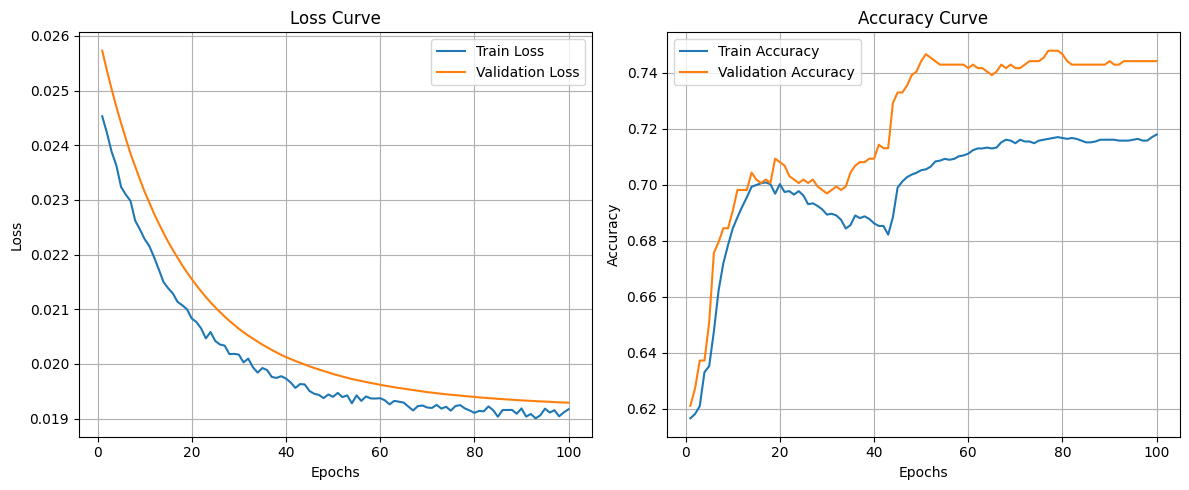

In [15]:
epochs_range = list(range(1, epochs + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(epochs_range, train_losses, label="Train Loss")
axs[0].plot(epochs_range, val_losses, label="Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss Curve")
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
axs[1].plot(epochs_range, val_accuracies, label="Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


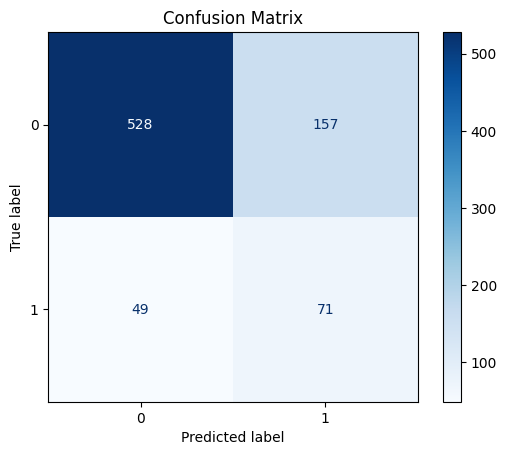

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_tensor)

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
